# Imports

In [1]:
import importlib
import json
import math
from itertools import islice
from pathlib import Path
from typing import Callable

import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from n2g import NeuronModel, NeuronStats
from transformer_lens import HookedTransformer

import thesis

importlib.reload(thesis)
from thesis.device import Device
from thesis.mas import html, WeightedSamplesStore

# Methods

In [2]:
def sorted(x):
    sorted_x = x.copy()
    sorted_x.sort()
    return sorted_x


def bootstrap_metric_std(
    x: np.ndarray, metric: Callable[[np.ndarray], np.ndarray], num_samples: int
) -> tuple[float, float]:
    samples = np.random.choice(x, (num_samples, x.size), replace=True)
    means = metric(samples)
    std = means.std()
    return metric(x), std


def bootstrap_mean_std(x: np.ndarray, num_samples: int) -> tuple[float, float]:
    return bootstrap_metric_std(x, lambda x: x.mean(axis=-1), num_samples)


def bootstrap_min_std(x: np.ndarray, num_samples: int) -> tuple[float, float]:
    return bootstrap_metric_std(x, lambda x: x.min(axis=-1), num_samples)


def bootstrap_test(x: np.ndarray, y: np.ndarray, num_samples: int) -> float:
    x_mean = x.mean()
    y_mean = y.mean()
    t = (x_mean - y_mean) / math.sqrt(x.var() / x.size + y.var() / y.size)
    z = (x.sum() + y.sum()) / (x.size + y.size)
    x_prime = x - x_mean + z
    y_prime = y - y_mean + z
    samples_x = np.random.choice(x_prime, (num_samples, x.size), replace=True)
    samples_y = np.random.choice(y_prime, (num_samples, y.size), replace=True)
    x_means = samples_x.mean(axis=1)
    y_means = samples_y.mean(axis=1)
    x_vars = samples_x.var(axis=1)
    y_vars = samples_y.var(axis=1)
    t_samples = (x_means - y_means) / np.sqrt(x_vars / x.size + y_vars / y.size)
    return (t_samples <= t).mean()

# Data

In [3]:
N_MLP = 2048
N_SAE = 2048 * 8
N_TOTAL = N_MLP + N_SAE
N_BOOTSTRAP = 1000
FIRING_THRESHOLD_BIN = 7  # Should match all bins with activation < 0.5

outputs_path = Path("outputs") / "models"
stats_path = outputs_path / "stats.json"

with stats_path.open("r", encoding="utf-8") as f:
    stats_json = json.load(f)
    stats = [NeuronStats.from_dict(neuron_stats) for neuron_stats in stats_json]

assert len(stats) == N_TOTAL, f"Expected {N_TOTAL} stats, got {len(stats)}"

device = Device.get()

mas_path = Path("../outputs/gelu-1l_sae_store.zip")
mas_store = WeightedSamplesStore.load(mas_path, device)

In [4]:
def get_stats(neuron_stats: list[NeuronStats], get: Callable[[NeuronStats], float]) -> list[float]:
    return [get(neuron) for neuron in neuron_stats]


def stats_df(stats: list[NeuronStats], mas_store: WeightedSamplesStore, group: str) -> pd.DataFrame:
    densities = mas_store.feature_densities.cpu().numpy()
    firing_densities = densities[:, FIRING_THRESHOLD_BIN:].sum(axis=1) / densities.sum(axis=1)

    return pd.DataFrame(
        {
            "accuracy": get_stats(stats, lambda x: x.accuracy),
            "firing_recall": get_stats(stats, lambda x: x.firing.recall),
            "firing_precision": get_stats(stats, lambda x: x.firing.precision),
            "firing_f1": get_stats(stats, lambda x: x.firing.f1_score),
            "firing_count": get_stats(stats, lambda x: x.firing.count),
            "non_firing_recall": get_stats(stats, lambda x: x.non_firing.recall),
            "non_firing_precision": get_stats(stats, lambda x: x.non_firing.precision),
            "non_firing_f1": get_stats(stats, lambda x: x.non_firing.f1_score),
            "non_firing_count": get_stats(stats, lambda x: x.non_firing.count),
            "density": firing_densities,
            "group": [group] * len(stats),
        }
    )


mlp_df = stats_df(stats[:N_MLP], mas_store, "mlp")
sae_df = stats_df(stats[N_MLP:], mas_store, "sae")

df = pd.concat([mlp_df, sae_df])

In [5]:
mlp_firing_recall = mlp_df["firing_recall"].to_numpy()
sae_firing_recall = sae_df["firing_recall"].to_numpy()

mlp_firing_precision = mlp_df["firing_precision"].to_numpy()
sae_firing_precision = sae_df["firing_precision"].to_numpy()

mlp_firing_f1_score = mlp_df["firing_f1"].to_numpy()
sae_firing_f1_score = sae_df["firing_f1"].to_numpy()

# NaN and means

In [6]:
mlp_nan_ratio = mlp_firing_f1_score[np.isnan(mlp_firing_f1_score)].size / mlp_firing_f1_score.size
sae_nan_ratio = sae_firing_f1_score[np.isnan(sae_firing_f1_score)].size / sae_firing_f1_score.size

mlp_firing_recall_mean = mlp_firing_recall.mean()
sae_firing_recall_mean = sae_firing_recall.mean()

mlp_firing_precision_mean = mlp_firing_precision[~np.isnan(mlp_firing_precision)].mean()
sae_firing_precision_mean = sae_firing_precision[~np.isnan(sae_firing_precision)].mean()

mlp_firing_f1_score_mean = mlp_firing_f1_score[~np.isnan(mlp_firing_f1_score)].mean()
sae_firing_f1_score_mean = sae_firing_f1_score[~np.isnan(sae_firing_f1_score)].mean()

print(f"MLP nan ratio: {mlp_nan_ratio}")
print(f"SAE nan ratio: {sae_nan_ratio}")
print()
print(f"MLP firing recall mean: {mlp_firing_recall_mean}")
print(f"SAE firing recall mean: {sae_firing_recall_mean}")
print()
print(f"MLP firing precision mean: {mlp_firing_precision_mean}")
print(f"SAE firing precision mean: {sae_firing_precision_mean}")
print()
print(f"MLP firing F1 score mean: {mlp_firing_f1_score_mean}")
print(f"SAE firing F1 score mean: {sae_firing_f1_score_mean}")

MLP nan ratio: 0.00048828125
SAE nan ratio: 0.00567626953125

MLP firing recall mean: 0.40687196145187055
SAE firing recall mean: 0.4061269767045479

MLP firing precision mean: 0.2204152301911238
SAE firing precision mean: 0.3038743536571697

MLP firing F1 score mean: 0.24740543979492954
SAE firing F1 score mean: 0.31288404150477683


# Plots

In [7]:
counts = {"mlp": N_MLP, "sae": N_SAE}
notnull_counts = {
    "mlp": (1 - mlp_nan_ratio) * N_MLP,
    "sae": (1 - sae_nan_ratio) * N_SAE,
}
notnull_df = df[df["firing_precision"].notnull()]

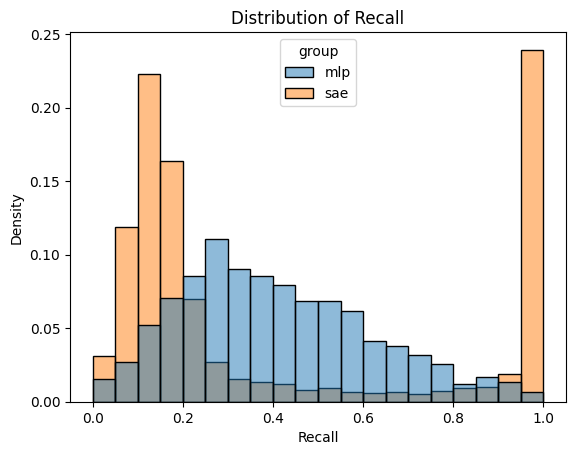

In [8]:
sns.histplot(data=df, x="firing_recall", hue="group", bins=20, weights=1 / df["group"].map(counts))
plt.xlabel("Recall")
plt.ylabel("Density")
plt.title("Distribution of Recall")
plt.show()

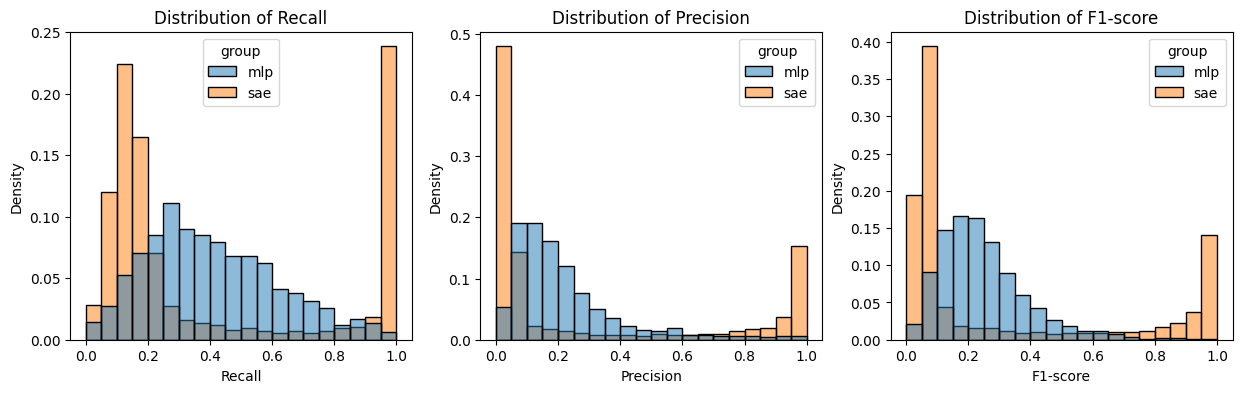

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

plot_info = [("firing_recall", "Recall"), ("firing_precision", "Precision"), ("firing_f1", "F1-score")]
for ax, (column, title) in zip(axes, plot_info, strict=True):
    sns.histplot(
        data=notnull_df, x=column, hue="group", bins=20, weights=1 / notnull_df["group"].map(notnull_counts), ax=ax
    )
    ax.set_xlabel(title)
    ax.set_ylabel("Density")
    ax.set_title(f"Distribution of {title}")


plt.show()

<Axes: xlabel='firing_recall', ylabel='firing_precision'>

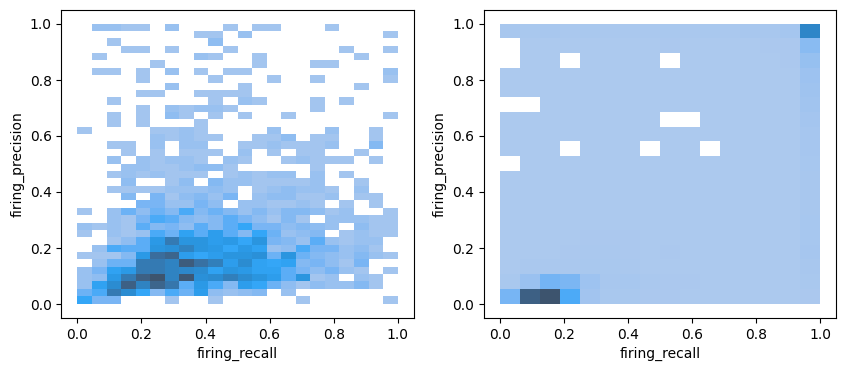

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))


sns.histplot(data=notnull_df[notnull_df["group"].eq("mlp")], x="firing_recall", y="firing_precision", ax=axes[0])
sns.histplot(data=notnull_df[notnull_df["group"].eq("sae")], x="firing_recall", y="firing_precision", ax=axes[1])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))


sns.histplot(data=notnull_df[notnull_df["group"].eq("mlp")], x="firing_recall", y="density", ax=axes[0])
sns.histplot(data=notnull_df[notnull_df["group"].eq("sae")], x="firing_recall", y="density", ax=axes[1])

# Tests
Only done on roughly the best half of each set of features due to issues with NaN's

In [11]:
MLP_START_INDEX = -int(math.ceil((1 - sae_nan_ratio) * N_MLP))
SAE_START_INDEX = -int(math.ceil((1 - sae_nan_ratio) * N_SAE))
best_mlp_firing_recall = sorted(mlp_firing_recall)[MLP_START_INDEX:]
best_sae_firing_recall = sorted(sae_firing_recall)[SAE_START_INDEX:]
mlp_recall_mean, mlp_recall_mean_std = bootstrap_mean_std(best_mlp_firing_recall, N_BOOTSTRAP)
sae_recall_mean, sae_recall_mean_std = bootstrap_mean_std(best_sae_firing_recall, N_BOOTSTRAP)
print(f"MLP firing recall mean: {mlp_recall_mean}   std: {mlp_recall_mean_std}")
print(f"SAE firing recall mean: {sae_recall_mean}   std: {sae_recall_mean_std}")
recall_stds = abs(mlp_recall_mean - sae_recall_mean) / (mlp_recall_mean_std + sae_recall_mean_std)
recall_chebychev_p = 1 / (recall_stds**2)
recall_bootstrap_p = bootstrap_test(best_mlp_firing_recall, best_sae_firing_recall, N_BOOTSTRAP)
print(f"stds: {recall_stds:10.2f}    chebychev p: {recall_chebychev_p:10.4f}")
print(f"p-value: {recall_bootstrap_p:10.4f}")
print()

best_mlp_firing_precision = sorted(mlp_firing_precision[~np.isnan(mlp_firing_precision)])[MLP_START_INDEX:]
best_sae_firing_precision = sorted(sae_firing_precision[~np.isnan(sae_firing_precision)])[SAE_START_INDEX:]
mlp_precision_mean, mlp_precision_mean_std = bootstrap_mean_std(best_mlp_firing_precision, N_BOOTSTRAP)
sae_precision_mean, sae_precision_mean_std = bootstrap_mean_std(best_sae_firing_precision, N_BOOTSTRAP)
print(f"MLP firing precision mean: " f"{mlp_precision_mean}   std: {mlp_precision_mean_std}")
print(f"SAE firing precision mean: " f"{sae_precision_mean}   std: {sae_precision_mean_std}")
precision_stds = abs(mlp_precision_mean - sae_precision_mean) / (mlp_precision_mean_std + sae_precision_mean_std)
precision_chebychev_p = 1 / (precision_stds**2)
precision_bootstrap_p = bootstrap_test(best_mlp_firing_precision, best_sae_firing_precision, N_BOOTSTRAP)
print(f"stds: {precision_stds:10.2f}    chebychev p: {precision_chebychev_p:10.4f}")
print(f"p-value: {precision_bootstrap_p:10.4f}")
print()

best_mlp_firing_f1_score = sorted(mlp_firing_f1_score[~np.isnan(mlp_firing_f1_score)])[MLP_START_INDEX:]
best_sae_firing_f1_score = sorted(sae_firing_f1_score[~np.isnan(sae_firing_f1_score)])[SAE_START_INDEX:]
mlp_f1_score_mean, mlp_f1_score_mean_std = bootstrap_mean_std(best_mlp_firing_f1_score, N_BOOTSTRAP)
sae_f1_score_mean, sae_f1_score_mean_std = bootstrap_mean_std(best_sae_firing_f1_score, N_BOOTSTRAP)
print(f"MLP firing F1 score mean: {mlp_f1_score_mean}   std: {mlp_f1_score_mean_std}")
print(f"SAE firing F1 score mean: {sae_f1_score_mean}   std: {sae_f1_score_mean_std}")
f1_score_stds = abs(mlp_f1_score_mean - sae_f1_score_mean) / (mlp_f1_score_mean_std + sae_f1_score_mean_std)
f1_score_chebychev_p = 1 / (f1_score_stds**2)
f1_score_bootstrap_p = bootstrap_test(best_mlp_firing_f1_score, best_sae_firing_f1_score, N_BOOTSTRAP)
print(f"stds: {f1_score_stds:10.2f}    chebychev p: {f1_score_chebychev_p:10.4f}")
print(f"p-value: {f1_score_bootstrap_p:10.4f}")

MLP firing recall mean: 0.40902830148030705   std: 0.004486394453549816
SAE firing recall mean: 0.4084454230143829   std: 0.0030942744647800575
stds:       0.08    chebychev p:   169.1450
p-value:     0.5570

MLP firing precision mean: 0.2214638977103255   std: 0.003915191801641979
SAE firing precision mean: 0.30387435365716975   std: 0.0029977787675000327
stds:      11.92    chebychev p:     0.0070
p-value:     0.0000

MLP firing F1 score mean: 0.24857661277041546   std: 0.0032269774756003003
SAE firing F1 score mean: 0.31288404150477683   std: 0.003072489758303008
stds:      10.21    chebychev p:     0.0096
p-value:     0.0000


# Investigation

In [12]:
import torch

device = Device.get()

sae_mas_store = MASStore.load(outputs_path / "gelu-1l-sae_store.zip", device)
print(sae_mas_store.feature_activations()[0].sum())

model: HookedTransformer = HookedTransformer.from_pretrained("gelu-1l", device=device.torch())  # type: ignore[reportUnknownVariableType]
lm = model

torch.cuda.empty_cache()

tensor(2829.4541, device='cuda:0')
Loaded pretrained model gelu-1l into HookedTransformer


In [18]:
# Take all features so indexing is consistent.
mas_samples = sae_mas_store.feature_samples()
mas_activations = sae_mas_store.feature_activations()

nan_features = df.index[df["firing_f1"].isnull() & df["group"].eq("sae")]
perfect_features = df.index[df["firing_f1"].eq(1) & df["group"].eq("sae")]
print(f"Number of NaN features: {len(nan_features)}/{N_SAE} ({len(nan_features) / N_SAE:.2%})")
print(f"Number of perfect features: {len(perfect_features)}/{N_SAE} ({len(perfect_features) / N_SAE:.2%})")

num_samples = 10
graph_dir = outputs_path / "models"

nan_dir = outputs_path / "nan_samples"
nan_dir.mkdir(exist_ok=True, parents=True)
for index in islice(nan_features, num_samples):
    graph_file = graph_dir / f"{index}.dot"
    graph = graphviz.Source.from_file(graph_file)
    html_str = html.generate_html(model, mas_samples[index], mas_activations[index], n2g_source=graph)
    with (nan_dir / f"{index}.html").open("w", encoding="utf-8") as f:
        f.write(html_str)

bad_dir = outputs_path / "bad_samples"
bad_dir.mkdir(exist_ok=True, parents=True)
bad_indices = df.sort_values("firing_precision").index[df["group"].eq("sae")]
for index in islice(bad_indices, num_samples):
    graph_file = graph_dir / f"{index}.dot"
    graph = graphviz.Source.from_file(graph_file)
    html_str = html.generate_html(model, mas_samples[index], mas_activations[index], n2g_source=graph)
    with (bad_dir / f"{index}.html").open("w", encoding="utf-8") as f:
        f.write(html_str)


perfect_dir = outputs_path / "perfect_samples"
perfect_dir.mkdir(exist_ok=True, parents=True)
for index in islice(perfect_features, num_samples):
    graph_file = graph_dir / f"{index}.dot"
    graph = graphviz.Source.from_file(graph_file)
    html_str = html.generate_html(model, mas_samples[index], mas_activations[index], n2g_source=graph)
    with (perfect_dir / f"{index}.html").open("w", encoding="utf-8") as f:
        f.write(html_str)

Number of NaN features: 93/16384 (0.57%)
Number of perfect features: 1322/16384 (8.07%)


In [14]:
import asyncio
import pickle
from typing import Iterable

import aiofiles
import nest_asyncio

nest_asyncio.apply()


models_path = outputs_path / "models"


async def read_model(index: int) -> NeuronModel:
    async with aiofiles.open(models_path / f"{index}.pkl", "rb") as f:
        data = await f.read()
    return pickle.loads(data)


def read_models(indices: Iterable[int]) -> list[NeuronModel]:
    return asyncio.get_event_loop().run_until_complete(asyncio.gather(*[read_model(index) for index in indices]))


perfect_models = read_models(perfect_features)

In [15]:
node_count_counts = {}
for feature_model in perfect_models:
    node_count = feature_model.node_count
    if node_count not in node_count_counts:
        node_count_counts[node_count] = 0
    node_count_counts[node_count] += 1
max_node_count = max(node_count_counts.keys())
for node_count in range(1, max_node_count + 1):
    if node_count in node_count_counts:
        print(f"{node_count:03}: {node_count_counts[node_count]}")

003: 193
005: 1
006: 41
007: 2
008: 2
009: 15
010: 2
011: 5
012: 8
013: 1
014: 2
015: 11
017: 1
018: 2
019: 1
020: 3
021: 1
022: 2
023: 2
024: 2
026: 2
027: 6
030: 3
031: 2
033: 6
034: 2
035: 4
036: 5
038: 1
039: 1
040: 1
041: 2
042: 2
044: 2
045: 6
047: 3
048: 3
049: 1
050: 2
051: 1
052: 1
054: 2
056: 1
057: 3
058: 1
059: 2
060: 2
062: 1
063: 1
066: 1
067: 2
068: 1
069: 2
072: 3
073: 1
074: 1
075: 1
076: 2
077: 2
078: 2
080: 1
081: 1
082: 3
086: 1
089: 3
090: 3
092: 1
093: 1
094: 1
096: 1
097: 1
098: 4
100: 3
102: 3
106: 3
107: 1
108: 2
109: 2
110: 1
114: 4
115: 2
116: 1
117: 2
118: 3
119: 3
120: 2
122: 1
123: 1
124: 2
125: 2
126: 1
127: 3
128: 4
129: 1
130: 2
131: 1
132: 3
133: 2
134: 2
136: 1
137: 1
138: 1
140: 2
142: 2
144: 1
145: 1
148: 4
150: 2
153: 1
156: 1
157: 1
158: 3
159: 3
160: 1
161: 1
163: 1
164: 1
165: 1
166: 2
168: 2
171: 1
172: 2
173: 1
174: 1
175: 1
176: 1
177: 1
178: 1
181: 1
184: 1
185: 1
186: 1
187: 2
190: 1
191: 1
196: 1
197: 2
199: 2
200: 2
204: 1
205: 1
210: 1
2

In [24]:
import torch
from n2g import NeuronStats

index = 4985
model_stats = df.loc[index]
feature_model = await read_model(index)

samples = sae_mas_store.feature_samples()[index]
activations = sae_mas_store.feature_activations()[index]
feature_model_activations = torch.zeros_like(activations)
for sample_index, sample in enumerate(samples):
    sample_strs: list[str] = model.to_str_tokens(sample)
    [features_model_sample_activations] = feature_model.forward([sample_strs])
    feature_model_activations[sample_index] = torch.tensor(features_model_sample_activations)

html_str = html.generate_html(
    model, samples, feature_model_activations, n2g_source=graphviz.Source(feature_model.graphviz().source)
)
with open(f"outputs/models/n2g_activations_{index}.html", "w", encoding="utf-8") as f:
    f.write(html_str)

firings = (activations >= 0.5).ravel()
pred_firings = (feature_model_activations >= 0.5).ravel()
stats = NeuronStats.from_firings(firings.cpu().numpy(), pred_firings.cpu().numpy())

print(stats)
print(f"df stats: {model_stats}")


print(f"{feature_model.root[0].children.keys()}")

accuracy=0.9739990234375 non_firing=ClassStats(precision=0.9738842569887199, recall=1.0, f1_score=0.9867693645568048, count=7943) firing=ClassStats(precision=1.0, recall=0.14457831325301204, f1_score=0.25263157894736843, count=249)
df stats: accuracy                0.936279
firing_recall           0.109091
firing_precision        0.027523
firing_f1               0.043956
firing_count                  55
non_firing_recall       0.947538
non_firing_precision    0.987365
non_firing_f1           0.967041
non_firing_count            4041
group                        sae
Name: 4985, dtype: object
dict_keys(['O', 'M', 'P', 'H', 'C', 'F', 'B', 'N', 'D', 'J', 'T', 'W', 'L', 'A', 'R', 'I', 'V', 'K', 'Y', 'E', 'U', 'S'])
